# Forecasting Temperature for Haiti

---

<div class="alert alert-block alert-success">
    
## Summary:

#### Use timeseries methods to determine future temperatures using previously observed temperature data. I am focusing on Haiti specifically.

### Findings:
#### The Holt's Linear Trend proved to be the best model for prediction

---

### Project Goal

- Predict future temperatures of a location of your choosing

- Initial questions:
    1. 
    
### Project Planning

1. Acquire from .csv
    - Peer through datasets
    - Research about climate change
    - Pick a location to examine
2. Prepare
    - Find data associated with that location and potentially merge .csv
    - Create separate files 
3. Explore
    - Look for additional insights
4. Model
    - Find the best Model
5. Report Findings

---

## Imports:

In [1]:
# Standard imports
import numpy as np
import pandas as pd

# For statistical modeling
import scipy.stats as stats
from math import sqrt 

# For data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# To avoid deprecation and other warnings
import warnings
warnings.filterwarnings('ignore')

# For modeling
# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
# holt's linear trend model
from statsmodels.tsa.api import Holt
import statsmodels.api as sm

from matplotlib.ticker import StrMethodFormatter
from matplotlib.dates import DateFormatter

# working with dates
from datetime import datetime

import os

# For acquisition
path = '/Users/everettclark/Desktop/codeup-data-science/time-series-exercises/archive/'

---

<div class="alert alert-block alert-warning">
    
# Acquisition:

In [2]:
df = pd.read_csv(f'{path}GlobalLandTemperaturesByCountry.csv')
df.head(3)

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577462 entries, 0 to 577461
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             577462 non-null  object 
 1   AverageTemperature             544811 non-null  float64
 2   AverageTemperatureUncertainty  545550 non-null  float64
 3   Country                        577462 non-null  object 
dtypes: float64(2), object(2)
memory usage: 17.6+ MB


In [4]:
df[df.Country == 'Haiti'].isnull().sum()

dt                                0
AverageTemperature               46
AverageTemperatureUncertainty    46
Country                           0
dtype: int64

---

<div class="alert alert-block alert-warning">

# Preparation: 

In [5]:
haiti = df[df.Country == 'Haiti']

# Change from object type to datetime
haiti.dt = pd.to_datetime(haiti.dt, format='%Y-%m-%d ')

# Rename columns to simplify 
haiti.rename(columns={'dt': 'date', 
                      'AverageTemperature': 'temp', 
                      'AverageTemperatureUncertainty': 'temp_vari', 
                      'Country': 'country'}, 
             inplace=True)

# Fill nulls with a constant 
haiti.temp_vari.fillna(haiti.temp_vari.mean(),inplace=True)
haiti.temp.fillna(haiti.temp.mean(),inplace=True)

# Convert from Celsius to Fahrenheit
haiti.temp = (haiti.temp * 9/5 +32)

# New columns
haiti['month'] = haiti.date.dt.month  
haiti['year'] = haiti.date.dt.year

# Set the index
haiti = haiti.set_index('date')

haiti.head(3)

,temp,temp_vari,country,month,year
date,,,,,
1824-01-01,76.9766,0.908,Haiti,1,1824
1824-02-01,75.1892,1.953,Haiti,2,1824
1824-03-01,78.4544,2.162,Haiti,3,1824


In [6]:
haiti.country.value_counts()

Haiti    2277
Name: country, dtype: int64

---

<div class="alert alert-block alert-warning">

# Exploration and Pre-Processing:

<function matplotlib.pyplot.show(close=None, block=None)>

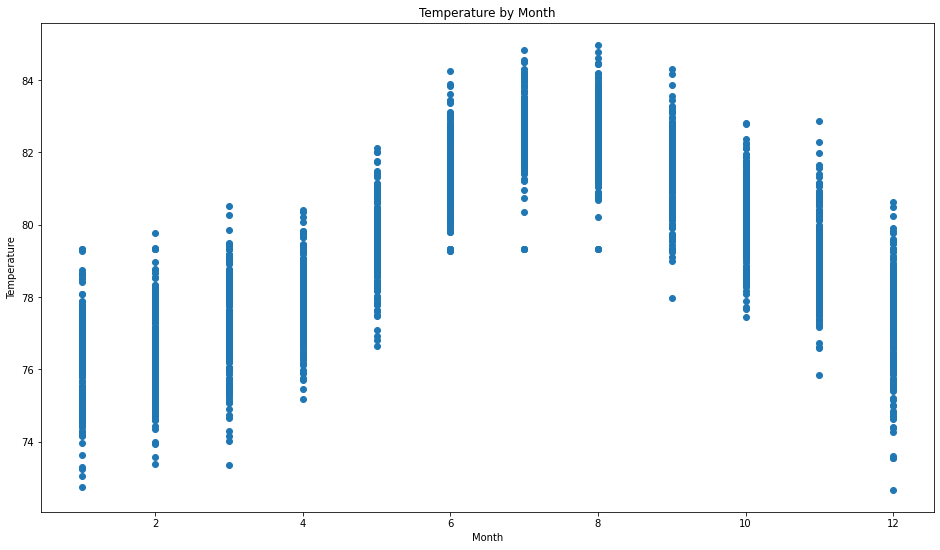

In [7]:
plt.figure(figsize=(16,9))
plt.scatter(x=haiti.month, y=haiti.temp)
plt.xlabel('Month')
plt.ylabel('Temperature')
plt.title('Temperature by Month')
plt.show

### All temperatures fall within the 73 - 85 degree range year-round
Fairly tight temperature range

## Different view, looking for outliers

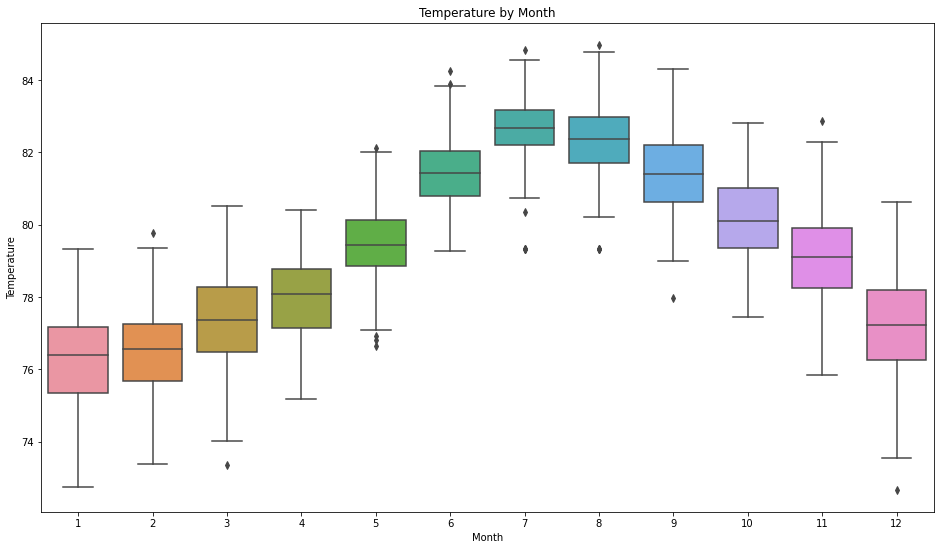

In [8]:
plt.figure(figsize=(16,9))
sns.boxplot(x=haiti.month, y=haiti.temp)
plt.xlabel('Month')
plt.ylabel('Temperature')
plt.title('Temperature by Month')
plt.show()

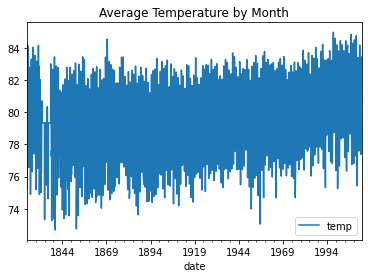

In [9]:
# Look at all months over time
haiti[['temp']].resample('M').mean().plot()
plt.title('Average Temperature by Month')
plt.show()

#### Month is too busy, so let's look at year

## Are there any drastic differences in temperature by year?

<Figure size 1152x648 with 0 Axes>

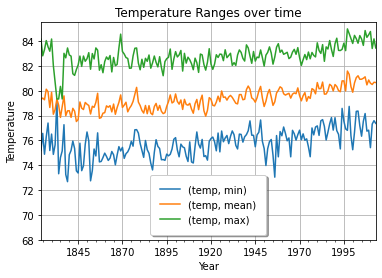

In [10]:
plt.figure(figsize=(16,9))
haiti[['temp']].resample('Y').agg(['min','mean','max']).plot()
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.title('Temperature Ranges over time')
plt.ylim(68,85.5)
plt.grid()
plt.show()

## Difference between minimum and Maximum Temperatures

<Figure size 1152x648 with 0 Axes>

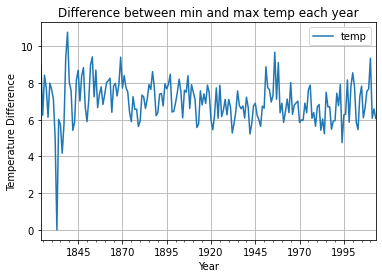

In [11]:
plt.figure(figsize=(16,9))
(haiti[['temp']].resample('Y').max() - haiti[['temp']].resample('Y').min()).plot()
plt.xlabel('Year')
plt.ylabel('Temperature Difference')
plt.title('Difference between min and max temp each year')
plt.grid()
plt.show()

## Beginning around 1920, there seems to begin a slight uptick in temps

<Figure size 1152x648 with 0 Axes>

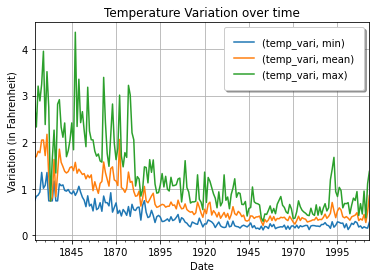

In [12]:
plt.figure(figsize=(16,9))
haiti[['temp_vari']].resample('Y').agg(['min','mean','max']).plot()
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.xlabel('Date')
plt.ylabel('Variation (in Fahrenheit)')
plt.title('Temperature Variation over time')
plt.grid()
plt.show()

<div class="alert alert-block alert-success">

# Exploration Findings:
### 1. There is only about a 10 degree difference from the minimum temperature and the maximum temperature of any given year
### 2. Temperature variation decreased as time went on
### 3. Few outlier temps for any given month

## Temperature variation decreases as time goes on
#### Temp variation is the difference in high temp to low temp, so maybe before 1895 their data was less accurate?

In [13]:
# Reassign by resampled year
haiti = haiti[['temp']].resample('Y').mean()

# Split: Train, Validate, Test

In [14]:
print(f'Train Size: {int(len(haiti) * 0.5)}')
print(f'Validate Size: {int(len(haiti) * 0.3)}')
print(f'Test Size: {int(len(haiti) * 0.2)}')

Train Size: 95
Validate Size: 57
Test Size: 38


In [15]:
train = haiti.iloc[:95]
validate = haiti.iloc[95:(95+57)]
test = haiti.iloc[(95+57):]

In [16]:
print(train.shape)
print(validate.shape)
print(test.shape)

(95, 1)
(57, 1)
(38, 1)


## Make sure split was done correctly

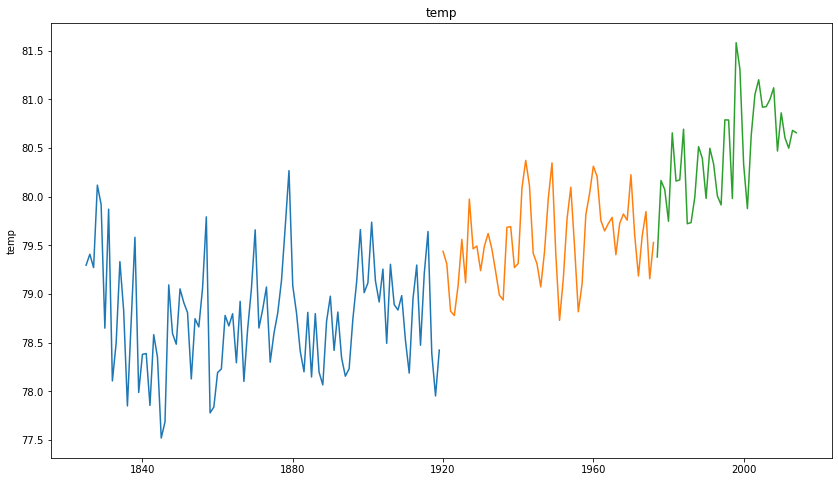

In [17]:
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

---

<div class="alert alert-block alert-warning">

# Modeling:

### Some Functions

In [18]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, 'RMSE: {:.5f}'.format(rmse))
    plt.show()
    
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

def make_predictions(amount=None):
    yhat_df = pd.DataFrame({'temp': [amount]},
                          index=validate.index)
    return yhat_df

In [19]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


## Predict with last known temperature

In [20]:
temp = train['temp'][-1:][0]
temp

78.42335

In [21]:
yhat_df = pd.DataFrame({'temp': [temp]},index=validate.index)
yhat_df.head(3)

,temp
date,
1919-12-31,78.42335
1920-12-31,78.42335
1921-12-31,78.42335


temp RMSE: 1.00000


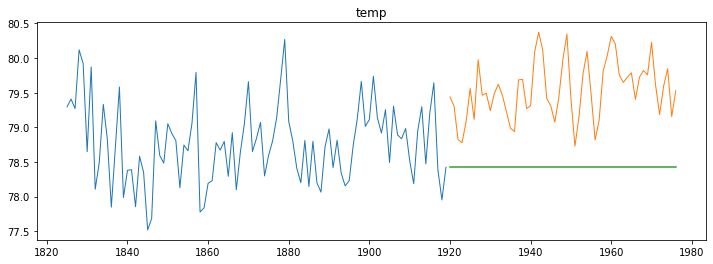

In [22]:
plot_and_eval('temp')

In [23]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,temp,1.0


## Simple Average

In [24]:
# compute simple average
temp = round(train['temp'].mean(), 2)
temp

78.76

In [25]:
yhat_df = make_predictions(temp)
yhat_df.head(3)

,temp
date,
1919-12-31,78.76
1920-12-31,78.76
1921-12-31,78.76


temp RMSE: 1.00000


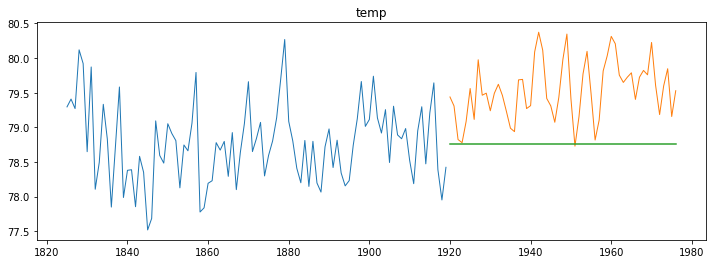

In [26]:
plot_and_eval('temp')

In [27]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,temp,1.0
1,simple_average,temp,1.0


In [28]:
periods = [1, 2, 3, 4, 10]

for p in periods: 
    avg_temp = round(train['temp'].rolling(p).mean()[-1], 2)
    yhat_df = make_predictions(avg_temp)
    model_type = str(p) + '_year_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                target_var = col)
        
eval_df

,model_type,target_var,rmse
0,last_observed_value,temp,1.0
1,simple_average,temp,1.0
2,1_year_moving_avg,temp,1.0
3,2_year_moving_avg,temp,1.0
4,3_year_moving_avg,temp,1.0
5,4_year_moving_avg,temp,1.0
6,10_year_moving_avg,temp,1.0


In [29]:
col = 'temp' 
# create our Holt's Object
model = Holt(train[col], exponential=True, damped=True)

# fit the holt's object
model = model.fit(optimized=True)

In [30]:
yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])

In [31]:
yhat_df[col] = round(yhat_items, 2)
yhat_df.head(3)

,temp
date,
1919-12-31,79.76
1920-12-31,79.76
1921-12-31,79.76


temp RMSE: 0.00000


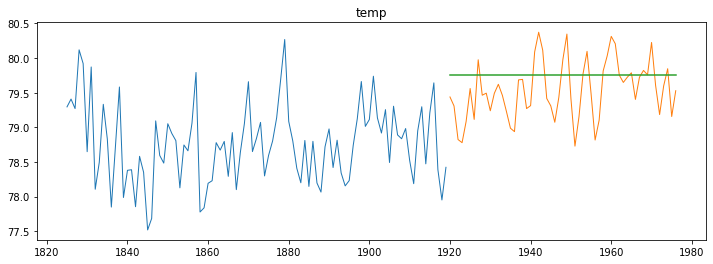

In [32]:
plot_and_eval(target_var = 'temp')

In [33]:
eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,temp,1.0
1,simple_average,temp,1.0
2,1_year_moving_avg,temp,1.0
3,2_year_moving_avg,temp,1.0
4,3_year_moving_avg,temp,1.0
5,4_year_moving_avg,temp,1.0
6,10_year_moving_avg,temp,1.0
7,holts_optimized,temp,0.0


In [34]:
yhat_df = pd.DataFrame(index=test.index, columns=test.columns)
yhat_df.amount = yhat_items

In [35]:

yhat = model.predict(start = test.index[0],
                              end = test.index[-1])

In [44]:
yhat_df.temp = yhat.values

In [45]:
yhat_df.head(3)

,temp
date,
1976-12-31,79.755692
1977-12-31,79.755692
1978-12-31,79.755692


In [46]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5, label='projection')
    plt.title(target_var)
    plt.legend()
    plt.show()

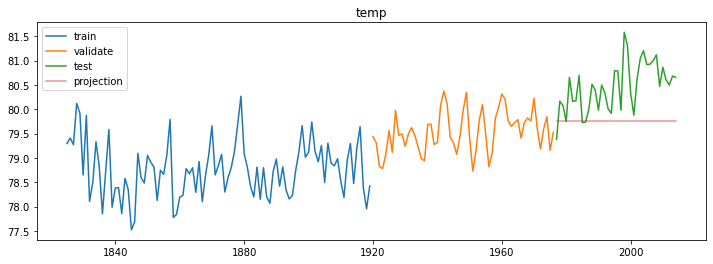

In [47]:
for col in train.columns:
    final_plot(col)

In [49]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

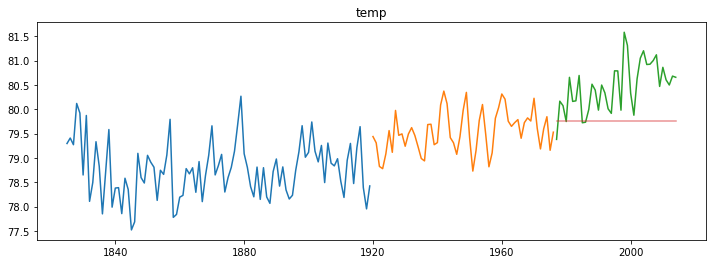

In [50]:
for col in train.columns:
    final_plot(col)

### The predicted doesn't appear to predict well for test

---

<div class="alert alert-block alert-success">

# Findings:
### 1. Holts Optimized, with exponential True had the lowest RMSE out of all models on validate
### 2. The mode ldoesn't appear ot work well with the test data

---

# Recommendations:
### 1. Haiti's temperature is fairly consistent throughout the year, so it would likely be better to try these model on a location with more variation to see if it still stands